**Model Skeleton**

Click [here](https://docs.google.com/document/d/1v8xBxDOmItnDbMlbNnb4KsY-F7_jp1F9RJ-aIMr2KHA/edit?usp=sharing) for a detailed description of the purpose of every code chunk

**Make sure to run this script on Google Colab to ensure compatability with Drive mounting**

**0) Import Dependencies and Mount Drive**

In [1]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm
import os, subprocess


import os
import shutil
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
from PIL import Image
import pandas as pd
import re
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import struct
import numpy as np
from torch.nn.functional import pad
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from collections import Counter


# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [2]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


**1. Configuration**

*Contains everything we can change about the model besides the model itself. The only other part of the code you should need to modify is in the section "Define Your Model and Train"*

- Paths to our data (**update these paths with the paths from your own drive**)
    - drive_image_folder (this is the drive folder with all images)
    - label_csv (this is the path with true labels "case_grade_match.csv")
    - meta_csv_full_scan (this is the path where the metadata is saved)

- Data to train on (**update these params with the cases you want to train on**)
    - train_cases
    - test_cases
    - validation_cases

- Filtering Parameters (**update these params with the stains and sizes you want to train on**)
    - target_stain
    - min_image_size
    - max_image_size
- Hyperparameters
    - lr (learning rate)
    - num_epochs (number of epochs)
    - batch_size

- Other Parameters
    - force_rebuild_metadata_full
        - This will rebuild the metadata each time
        - **Only set to false if you have not changed any other parameters** (meaning that your filtering params and data to train on have not changed)

    - Device
        - Controls what hardware (GPU vs. CPU etc) we use (defualt GPU)
    - num_workers
        - Param for the data loader. If num_workers > 0, we load + preprocess data in parallel with model training.
        - currently not in use bc data loading is fast




In [4]:
#Create train, test, and val lists

train_test_val_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")

train_list = train_test_val_df[train_test_val_df.Data == "Train"].Case.to_list()
test_list = train_test_val_df[train_test_val_df.Data == "Test"].Case.to_list()
val_list = train_test_val_df[train_test_val_df.Data == "Validate"].Case.to_list()

In [5]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths.csv",  # Explicitly local
    'model_directory': "/content/drive/MyDrive/CMIL_Models/Melan/resize_8batch",
    'batch_size': 8,
    'num_workers': 1, # Adjusted for potentially faster local I/O
    'lr': 5e-4,
    'early_stopping_patience': None,  # Optional, set to None or omit to disable
    'num_epochs': 15, # Keep as 1 for a quick test, adjust as needed
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': train_list,
    'test_cases': test_list,
    'validation_cases': val_list,
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 50,
    'max_image_size': 100000,
    'target_stain': 'melan'
}

# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stain for this run: {CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {CONFIG['local_image_folder']}") # Verify local path
if CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True


Cases included in initial full metadata scan: 77
Target stain for this run: melan
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


**Note** – the ```n_buckets``` input for our bucketing logic is not included in the CONFIG. You'll have to manually change it the code chunk where we create the boundaries and data loaders (see below in section 6). The default is just to keep ```n_buckets``` = number of batches.

**2) Build Metadata**

Uses 3 code chunks

1) Helper functions: help optimize build_metadata function

2) Build metadata function: creates metadata

3) Calling build metadata

In [6]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).
    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            # Check if path exists before scanning
            if not os.path.exists(path):
                print(f"⚠️ Directory not found: {path}. Skipping scan for this path.")
                return [] # Return empty iterator if path doesn't exist

            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path) # Recursive call
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts due to OSError: {e}")
        except FileNotFoundError: # Explicitly handle FileNotFoundError during scandir
             print(f"⚠️ Directory not found during scandir: {path}. Skipping.")
             return []
    return scan_dir(root)

In [7]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                # Ensure width/height are numeric for filtering, coerce errors to NaN then fill with -1
                df['width'] = pd.to_numeric(df['width'], errors='coerce').fillna(-1).astype(int)
                df['height'] = pd.to_numeric(df['height'], errors='coerce').fillna(-1).astype(int)

                df = df[((df.width  >= min_width) & (df.width  <= max_width)) | (df.width  == -1)] # inclusive min/max
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                if not df.empty:
                     # CRITICAL: Verify that paths are what you expect (local paths)
                    print(f"Example path from loaded metadata: {df['path'].iloc[0]}")
                return df
        except Exception as e:
            print(f"❗ Error loading or filtering {meta_csv}: {e}; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    if not os.path.exists(image_folder):
        print(f"❌ Error: Image folder for scanning does not exist: {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder} or its subdirectories.")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])
    print(f"Found {len(files)} PNG files during scan.")

    def proc(p):
        # p will be a full local path like /content/Patches_Apr27/case_001_match_xyz.png
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))

        if cid not in all_cases:
            return None
        if stain.lower() not in p.lower(): # Simple substring check for stain in path
            return None

        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else: # Fallback if not standard PNG header or IHDR not where expected
                with Image.open(p) as img:
                    w, h = img.size
        except Exception as e:
            # print(f"Warning: Could not get dimensions for {p}: {e}")
            pass # Keep w,h as -1

        # size filter (inclusive)
        if w != -1 and not (min_width <= w <= max_width and min_width <= h <= max_width):
            return None

        return {
            'path': p, # This path is now a local path
            'case_number': cid,
            'stain': stain.lower(), # Store the target stain
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Processing files"))

    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}' after filtering. Check scan and filters.")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    if not df.empty:
        print(f"Example path from NEWLY BUILT metadata: {df['path'].iloc[0]}")
    return df

In [8]:
# create metadata
full_meta_df = build_metadata(
    image_folder=CONFIG['local_image_folder'], # MODIFIED: Use the local image folder
    all_cases=all_cases_for_scan,
    meta_csv=CONFIG['meta_csv_full_scan'],
    stain=CONFIG['target_stain'],
    force_rebuild=CONFIG['force_rebuild_metadata_full'],
    min_width=CONFIG['min_image_size'],
    max_width=CONFIG['max_image_size'],
    num_workers=CONFIG['num_workers']
)

# Ensure full_meta_df is not empty before proceeding
if full_meta_df.empty:
    print("❌ Metadata DataFrame is empty. Cannot proceed. Please check previous steps, especially the image path and scan.")
    # exit() # Or handle appropriately

🔍 Scanning /content/Patches_Apr27 for stain='melan'…
Found 73301 PNG files during scan.


Processing files: 100%|██████████| 73301/73301 [00:02<00:00, 28100.75it/s]


✅ Built & saved 18657 rows to /content/metadata_full_scan_local_paths.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_24_unmatched_9_melan_patch51.png


**Note**: You might get an I/O error upon running the create metadata code chunk. This is because of occasional timeout errors with connecting to Google Drive given how large our patches folder is. Rerun the code chunks until now if you face this error, and it should work after a few retries (this is assuming you haven't messed with the CONFIG settings or metadata file). You may also want to try restarting the runtime and re-running all the code chunks.

**3. Load Labels**
- This loads in the class labels and creates a labels map

In [9]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")


🗺️  Created labels_map for 105 cases


**4. Define Transforms**

- **Important** The mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] values are specific to models that are pretrained on ImageNet. If your model was pretrained on a different dataset, your mean and std values should be calculated based on the properties of that dataset
- Adjust the transformations as per requirements of your specific model

In [10]:
# ─── TRANSFORMS ───────────────────────────
# These transforms are applied to individual images by the Dataset's __getitem__.

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.RandomHorizontalFlip(p=0.5),  # Common and simple
    transforms.RandomRotation(degrees=10),   # Small-angle rotation
    transforms.ColorJitter(                  # Mild color perturbation
        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

**5) Create Dataset Objects for Train, Test, and Validation**

1) Define dataset class

2) Create datasets for train, test, and val

In [11]:
# --- Corrected PatchDataset Class ---
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        # THIS LINE MUST EXECUTE BEFORE you try to access self.samples
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

        # NOW it's safe to print the length of self.samples
        print(f"DEBUG: Dataset initialized with {len(self.samples)} total samples.")

    def __len__(self) -> int:
        return len(self.samples)
    def __getitem__(self, idx: int):
            # The IndexError traceback means this 'idx' is out of range for 'self.samples'
            # The primary fix for that is ensuring __len__ and __init__ are correct
            # This print will help verify if it's still being called with bad indices
            # print(f"DEBUG: __getitem__ called with idx = {idx}. len(self.samples) = {len(self.samples)}")

            # Ensure idx is within bounds. If this check triggers, the problem is in __len__ or DataLoader
            if not (0 <= idx < len(self.samples)):
                raise IndexError(f"__getitem__ called with invalid index {idx}. Valid range is [0, {len(self.samples)-1}]")

            path, label = self.samples[idx] # This is the line that errors

            try:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                cid = int(case_pat.search(os.path.basename(path)).group(1))
                return img, label, cid
            except Exception as e:
                # --- CRITICAL FIX HERE ---
                # DO NOT return None. Instead, log the error and re-raise it.
                # This will force the DataLoader to stop at the first genuinely problematic image file.
                print(f"ERROR: Failed to load or process image at index {idx} from path: '{path}'. Error: {e}")
                raise # Re-raise the exception to stop execution and debug the root cause

In [12]:
# --- Splitting metadata and creating datasets ---
# (Small modifications to handle potentially empty full_meta_df)
if not full_meta_df.empty:
    train_meta = full_meta_df[full_meta_df['case_number'].isin(CONFIG['train_cases'])].reset_index(drop=True)
    val_meta   = full_meta_df[full_meta_df['case_number'].isin(CONFIG['validation_cases'])].reset_index(drop=True)
    test_meta  = full_meta_df[full_meta_df['case_number'].isin(CONFIG['test_cases'])].reset_index(drop=True)

    if train_meta.empty or val_meta.empty or test_meta.empty:
        print("⚠️ One or more metadata splits (train/val/test) are empty. Check case lists and filtering.")

    train_dataset = PatchDataset(train_meta, labels_map, transform=train_transform)
    val_dataset   = PatchDataset(val_meta, labels_map, transform=eval_transform)
    test_dataset  = PatchDataset(test_meta, labels_map, transform=eval_transform)

    print(f"✅ Train patches: {len(train_dataset)}")
    print(f"✅ Val patches: {len(val_dataset)}") # Fixed typo from Test to Val
    print(f"✅ Test patches: {len(test_dataset)}")
else:
    print("❌ Skipping dataset creation due to empty full_meta_df.")
    # Initialize empty datasets or handle error
    train_dataset, val_dataset, test_dataset = None, None, None

DEBUG: Dataset initialized with 9705 total samples.
DEBUG: Dataset initialized with 3746 total samples.
DEBUG: Dataset initialized with 4166 total samples.
✅ Train patches: 9705
✅ Val patches: 3746
✅ Test patches: 4166


**6) Data Loader**


In [13]:
# loaders if you are resizing
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], pin_memory=True, num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],  pin_memory=True, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],  pin_memory=True, num_workers=0, shuffle=False)

**7) Data Visualization and Summary Statistics**

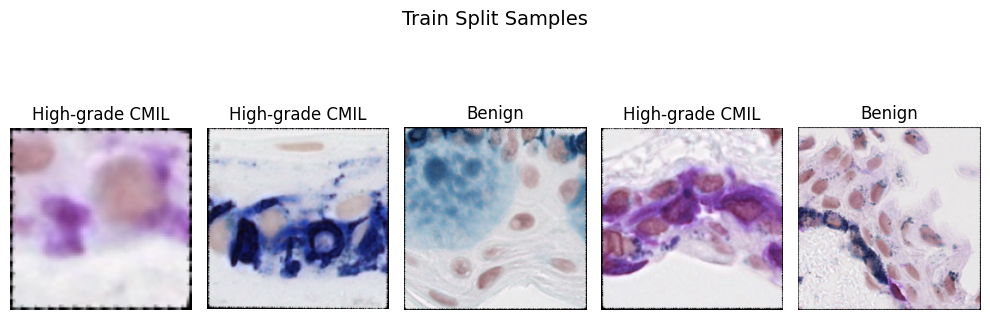


Train Set: Total Patches = 9705
  Benign (0):      4243
  High-grade (1):  5462

Validation Set: Total Patches = 3746
  Benign (0):      1104
  High-grade (1):  2642

Test Set: Total Patches = 4166
  Benign (0):      616
  High-grade (1):  3550


In [14]:
def visualize_random_samples(meta_df, title="Samples", n_samples=5, max_candidates=20, n_threads=5):
    """
    Efficiently sample & plot `n_samples` images by:
      - Sampling up to `max_candidates` rows
      - Loading in parallel (ThreadPoolExecutor of size `n_threads`)
      - Skipping unreadable files
    """
    # 1) pick up to max_candidates random rows
    sample_paths = meta_df.sample(
        n=min(max_candidates, len(meta_df)),
        random_state=42
    ).path.tolist()

    # 2) helper to try to open one image
    def try_load(path):
        try:
            img = Image.open(path).convert('RGB')
            arr = np.array(img) / 255.0
            return path, arr
        except Exception:
            return None

    # 3) load in parallel, stop once we have n_samples
    loaded = []
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = { exe.submit(try_load, p): p for p in sample_paths }
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                loaded.append(res)
            if len(loaded) >= n_samples:
                break

    if not loaded:
        print("⚠️  Could not load any sample images.")
        return

    # 4) plot however many we got (up to n_samples)
    n = len(loaded)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=n)
    fig.suptitle(title, fontsize=14)
    for ax, (path, arr) in zip(axes, loaded):
        ax.imshow(arr)
        cid = int(case_pat.search(os.path.basename(path)).group(1))
        cls = "Benign" if labels_map[cid] == 0 else "High-grade CMIL"
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Usage – should now be under 15 seconds:
visualize_random_samples(train_meta, title="Train Split Samples")

# ─── Step 10: Fast class-distribution counts ──────────────────────────────────
def print_meta_stats(name, meta_df):
    # count using metadata case_number → labels_map
    lbls = [ labels_map[cid] for cid in meta_df.case_number if cid in labels_map ]
    cnt = Counter(lbls)
    total = len(lbls)
    print(f"\n{name} Set: Total Patches = {total}")
    print(f"  Benign (0):      {cnt.get(0,0)}")
    print(f"  High-grade (1):  {cnt.get(1,0)}")

print_meta_stats("Train",      train_meta)
print_meta_stats("Validation", val_meta)
print_meta_stats("Test",       test_meta)


**8) Model Definition and Training**

**Define Generalized Model Traininng Function**

In [15]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess

def move_batch_to_device(images, labels, device):
    """
    Move a batch of images and labels to the given device (CPU/GPU).
    Handles both tensor inputs and lists/tuples of tensors.
    """
    if isinstance(images, (list, tuple)):
        images = torch.stack([img.to(device, non_blocking=True) for img in images])
    else:
        images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    return images, labels

def train_model(
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        config = CONFIG,
        scheduler=None,
        resume_from=None
    ):
    """
    Trains `model` using:
      - Automatic Mixed Precision (AMP)
      - Early stopping based on validation accuracy
      - Checkpoint saving for each epoch and best-model saving
      - GPU utilization logging
      - Saving of training/validation curves to disk

    Args:
      model:        PyTorch model to train.
      optimizer:    optimizer for model parameters.
      criterion:    loss function.
      train_loader: DataLoader for training data.
      val_loader:   DataLoader for validation data.
      config:       dict with keys:
                    - 'model_directory': where to save models/plots
                    - 'num_epochs':     maximum epochs to run
                    - 'device':         torch.device('cuda' or 'cpu')
                    - optional 'early_stopping_patience'
      scheduler:    (optional) learning rate scheduler.
      resume_from:  (optional) path to checkpoint to resume from.

    Returns:
      model: Trained model (with best weights loaded).
    """

    # Ensure required config keys exist
    required_keys = ["model_directory", "num_epochs", "device"]
    for key in required_keys:
        assert key in config, f"Missing CONFIG key: {key}"

    model_dir = config['model_directory']
    epochs = config['num_epochs']
    device = config['device']
    patience = config.get('early_stopping_patience', None)
    epochs_without_improvement = 0

    # Prepare device and cuDNN
    torch.backends.cudnn.benchmark = True
    model.to(device)

    # AMP scaler
    scaler = GradScaler()

    # Create directory for checkpoints and plots
    os.makedirs(model_dir, exist_ok=True)

    best_acc = 0.0
    start_epoch = 0

    # Optionally resume from checkpoint
    if resume_from is not None and os.path.exists(resume_from):
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint.get('val_accuracy', 0.0)
        print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")

    # Lists to track metrics for plotting
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Main training loop
    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        # Training phase with progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for batch in train_bar:
            if not batch:  # skip empty batches
                continue

            images, labels, _ = batch  # `_` = case_ids, ignored
            images, labels = move_batch_to_device(images, labels, device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backpropagation with AMP
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        # Compute and store average training loss
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # GPU utilization stats for debugging
        if torch.cuda.is_available():
            try:
                gpu_stats = subprocess.check_output(
                    [
                        "nvidia-smi",
                        "--query-gpu=utilization.gpu,utilization.memory,memory.used,memory.total",
                        "--format=csv,nounits,noheader"
                    ],
                    stderr=subprocess.DEVNULL
                ).decode("utf-8").strip()
                gpu_util, mem_util, mem_used, mem_total = [x.strip() for x in gpu_stats.split(',')]
                print(f"🔍 [GPU Util] GPU: {gpu_util}% | Mem: {mem_util}% "
                      f"({mem_used}/{mem_total} MiB)")
            except Exception:
                print(f"🔍 [CUDA] Alloc: {torch.cuda.memory_allocated(device)/1024**2:.1f} MiB | "
                      f"Cached: {torch.cuda.memory_reserved(device)/1024**2:.1f} MiB")

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                if not batch:
                    continue

                images, labels, _ = batch
                images, labels = move_batch_to_device(images, labels, device)

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                validation_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        # Compute and store validation loss and accuracy
        avg_val_loss = validation_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.4f}.. "
            f"Val Loss: {avg_val_loss:.4f}.. "
            f"Val Accuracy: {val_accuracy:.4f}"
        )

        # Save checkpoint after each epoch
        checkpoint_path = os.path.join(model_dir, f"model_epoch_{e+1}.pth")
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, checkpoint_path)

        # Save best model and handle early stopping
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_path = os.path.join(model_dir, "best_model.pth")
            torch.save(model.state_dict(), best_path)
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if patience is not None and epochs_without_improvement >= patience:
                print(f"⏹️ Early stopping triggered after {patience} epochs with no improvement.")
                break

        torch.cuda.empty_cache()

    # Plot training & validation curves
    epochs_range = list(range(start_epoch + 1, start_epoch + 1 + len(train_losses)))
    plt.figure(figsize=(12, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    # Save the figure to the model_directory
    curves_path = os.path.join(model_dir, f"training_curves_{start_epoch+1}_to_{start_epoch+len(train_losses)}.png")
    plt.savefig(curves_path)
    print(f"💾 Training curves saved to: {curves_path}")

    # Also display inline
    plt.show()

    return model

**Define Your Model and Train**

You need to specify 5 things (Do not specify anything else - they are already specified in the config)

1) Define your model object
```
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) # Use updated weights API
```
2) Unfreeze any layers that you want
```
for p in model.parameters(): p.requires_grad=False
```

3) Replace the classifier head if you want and modify feature extractor to include AdaptivePooling



```
# Modify feature extractor to include AdaptiveAvgPool2d
model.features = nn.Sequential(*list(model.features), nn.AdaptiveAvgPool2d((6, 6)))
in_ftrs = 256 * 6 * 6

# Custom classifier
model.classifier = nn.Sequential(
    nn.Dropout(), nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
    nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
    nn.Linear(4096, 2)
)
```



4) Define the optimizer and pass your trainable parameters

```
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"]
)
```

5) Optional: Define your class weighting (for class imbalance) and update the criterion

```
from collections import Counter

def compute_class_weights(meta_df, labels_map):
    # Extract per‐patch labels
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weight for under-represented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)

# Then your weighted‐loss setup becomes:
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

```

If you are having trouble implementing this, plug-in these instructions and your model into ChatGPT.

In [ ]:
# NOTE – NOT RUNNING CBAM FOR NOW

# ------------------------------
# 1) Define CBAM Components
# ------------------------------

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        # Two MLP layers: [in_channels → in_channels//reduction → in_channels]
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [batch_size, C, H, W]
        batch, C, H, W = x.size()
        # 1) Global Average Pooling → [batch, C]
        avg_pool = torch.mean(x.view(batch, C, -1), dim=2)
        # 2) Global Max Pooling → [batch, C]
        max_pool, _ = torch.max(x.view(batch, C, -1), dim=2)
        # 3) MLP on both
        avg_out = self.mlp(avg_pool)      # [batch, C]
        max_out = self.mlp(max_pool)      # [batch, C]
        out = avg_out + max_out           # [batch, C]
        # 4) Sigmoid → channel attention weights [batch, C]
        scale = self.sigmoid(out).view(batch, C, 1, 1)
        # 5) Multiply: broadcast over H×W
        return x * scale                  # [batch, C, H, W]

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        # Conv to produce 1-channel attention map
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(
            in_channels=2, out_channels=1,
            kernel_size=kernel_size, padding=padding, bias=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [batch_size, C, H, W]
        # 1) Compute AvgPool along channel dimension → [batch, 1, H, W]
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        # 2) Compute MaxPool along channel dimension → [batch, 1, H, W]
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        # 3) Concatenate → [batch, 2, H, W]
        cat = torch.cat([avg_pool, max_pool], dim=1)
        # 4) Conv → [batch, 1, H, W], apply sigmoid
        scale = self.sigmoid(self.conv(cat))
        # 5) Multiply
        return x * scale                  # [batch, C, H, W]

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(in_channels, reduction)
        self.spatial_att = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.channel_att(x)
        out = self.spatial_att(out)
        return out  # [batch, C, H, W]

In [16]:
# ------------------------------
# 2) Load Pretrained ResNet50
# ------------------------------
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# ------------------------------
# 3) Remove the original MaxPool
# ------------------------------
# model.maxpool = nn.Identity()  # Disables the fixed maxpool to rely on adaptive pooling + flexibility

# ------------------------------
# 4) Skip CBAM integration (baseline only)
# ------------------------------
# No CBAM components are added in the baseline model.

# ------------------------------
# 5) Freeze All Layers Initially
# ------------------------------
for param in model.parameters():
    param.requires_grad = False  # Everything frozen by default

# ------------------------------
# 5.5) UNFREEZE CLASSIFIER HEAD
# ------------------------------
# Only the final fully connected head is unfrozen in the baseline.
for param in model.fc.parameters():
    param.requires_grad = True

# ------------------------------
# 6) Replace the Final Classifier Head
# ------------------------------
in_ftrs = model.fc.in_features  # 2048 for ResNet50

model.fc = nn.Sequential(
    nn.Dropout(),
    nn.Linear(in_features=in_ftrs, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 2)  # Two-class classification: benign (0) vs high-grade (1)
)

# Send model to correct device (CPU or GPU)
model = model.to(CONFIG['device'])

# ------------------------------
# 7) Define Optimizer on Trainable Params
# ------------------------------
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # Only update unfrozen parameters
    lr=CONFIG["lr"]
)

# ------------------------------
# 8) Compute Class Weights & Define Criterion
# ------------------------------
def compute_class_weights(meta_df, labels_map):
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weights for underrepresented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(CONFIG['device'])
criterion = nn.CrossEntropyLoss(weight=cw_tensor)  # Weighted loss to handle class imbalance

# ------------------------------
# ✅ Model, Optimizer, and Criterion are ready
# ------------------------------

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


<ipython-input-15-1024635922>:72: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/15: 100%|██████████| 1214/1214 [02:34<00:00,  7.84it/s, loss=0.518]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 11% | Mem: 4% (889/23034 MiB)
Epoch: 1/15.. Train Loss: 0.5181.. Val Loss: 0.6805.. Val Accuracy: 0.5462
✅ New best model saved at epoch 1 with accuracy 0.5462


Epoch 2/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.08it/s, loss=0.446]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 0% | Mem: 0% (929/23034 MiB)
Epoch: 2/15.. Train Loss: 0.4453.. Val Loss: 0.6367.. Val Accuracy: 0.6340
✅ New best model saved at epoch 2 with accuracy 0.6340


Epoch 3/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.07it/s, loss=0.434]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 8% | Mem: 7% (929/23034 MiB)
Epoch: 3/15.. Train Loss: 0.4337.. Val Loss: 0.8624.. Val Accuracy: 0.5067


Epoch 4/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.07it/s, loss=0.417]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 7% | Mem: 7% (929/23034 MiB)
Epoch: 4/15.. Train Loss: 0.4169.. Val Loss: 0.6311.. Val Accuracy: 0.6498
✅ New best model saved at epoch 4 with accuracy 0.6498


Epoch 5/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.05it/s, loss=0.409]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 0% | Mem: 0% (929/23034 MiB)
Epoch: 5/15.. Train Loss: 0.4093.. Val Loss: 0.7217.. Val Accuracy: 0.5836


Epoch 6/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.08it/s, loss=0.405]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 7% | Mem: 7% (929/23034 MiB)
Epoch: 6/15.. Train Loss: 0.4052.. Val Loss: 0.6283.. Val Accuracy: 0.6484


Epoch 7/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.06it/s, loss=0.39]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 2% | Mem: 1% (929/23034 MiB)
Epoch: 7/15.. Train Loss: 0.3900.. Val Loss: 0.6938.. Val Accuracy: 0.5948


Epoch 8/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.07it/s, loss=0.378]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 8% | Mem: 8% (929/23034 MiB)
Epoch: 8/15.. Train Loss: 0.3778.. Val Loss: 0.6180.. Val Accuracy: 0.6532
✅ New best model saved at epoch 8 with accuracy 0.6532


Epoch 9/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.06it/s, loss=0.384]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 20% | Mem: 19% (929/23034 MiB)
Epoch: 9/15.. Train Loss: 0.3835.. Val Loss: 0.7052.. Val Accuracy: 0.6100


Epoch 10/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.08it/s, loss=0.371]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 7% | Mem: 7% (929/23034 MiB)
Epoch: 10/15.. Train Loss: 0.3709.. Val Loss: 0.7295.. Val Accuracy: 0.6012


Epoch 11/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.06it/s, loss=0.367]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 1% | Mem: 1% (929/23034 MiB)
Epoch: 11/15.. Train Loss: 0.3670.. Val Loss: 0.7787.. Val Accuracy: 0.6135


Epoch 12/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.05it/s, loss=0.358]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 7% | Mem: 7% (929/23034 MiB)
Epoch: 12/15.. Train Loss: 0.3576.. Val Loss: 0.6963.. Val Accuracy: 0.6172


Epoch 13/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/15: 100%|██████████| 1214/1214 [02:29<00:00,  8.10it/s, loss=0.362]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 2% | Mem: 3% (929/23034 MiB)
Epoch: 13/15.. Train Loss: 0.3614.. Val Loss: 0.7460.. Val Accuracy: 0.6017


Epoch 14/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/15: 100%|██████████| 1214/1214 [02:30<00:00,  8.09it/s, loss=0.349]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 9% | Mem: 8% (929/23034 MiB)
Epoch: 14/15.. Train Loss: 0.3486.. Val Loss: 0.7262.. Val Accuracy: 0.6103


Epoch 15/15:   0%|          | 0/1214 [00:00<?, ?it/s]<ipython-input-15-1024635922>:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/15: 100%|██████████| 1214/1214 [02:29<00:00,  8.11it/s, loss=0.364]
<ipython-input-15-1024635922>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 7% | Mem: 7% (929/23034 MiB)
Epoch: 15/15.. Train Loss: 0.3638.. Val Loss: 0.7284.. Val Accuracy: 0.6060
💾 Training curves saved to: /content/drive/MyDrive/CMIL_Models/Melan/resize_8batch/training_curves_1_to_15.png


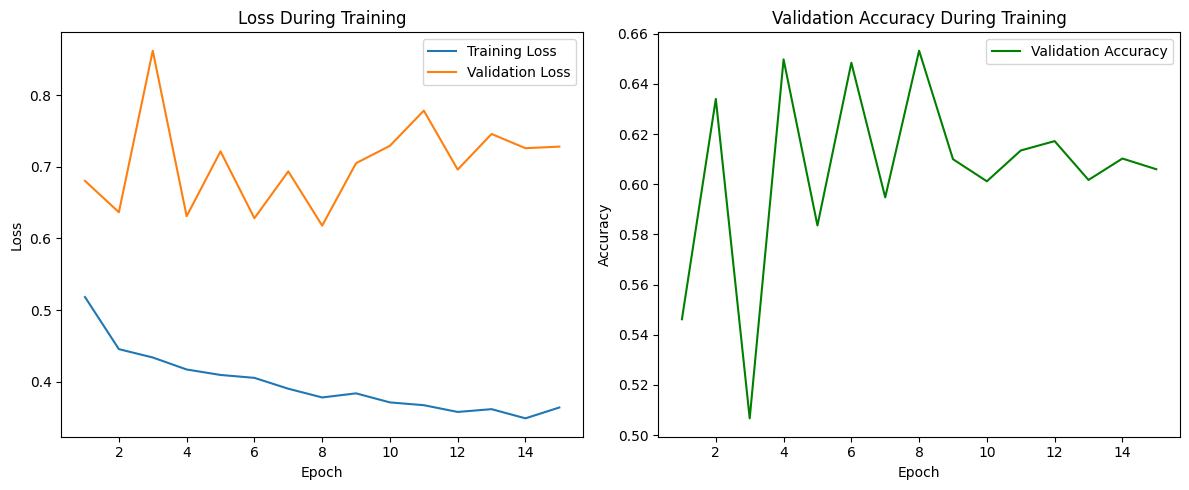

In [17]:
torch.cuda.empty_cache()

trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    scheduler=None,
    resume_from=None
)

**9. Model Evaluation**


=== Test Set Performance ===
Accuracy      : 0.6207
Precision     : 0.9429
Recall        : 0.5907
F1 Score      : 0.7264

Classification Report:
                 precision    recall  f1-score   support

         Benign       0.25      0.79      0.38       616
High-grade CMIL       0.94      0.59      0.73      3550

       accuracy                           0.62      4166
      macro avg       0.60      0.69      0.55      4166
   weighted avg       0.84      0.62      0.68      4166



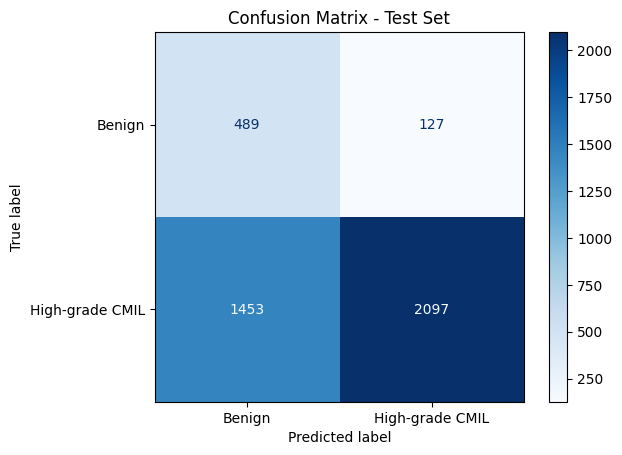

In [18]:
def evaluate_model_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:  # `_` = case IDs (optional)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Compute Metrics ===
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n=== Test Set Performance ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Benign", "High-grade CMIL"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "High-grade CMIL"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.show()

# === Run Evaluation ===
evaluate_model_on_test(trained_model, test_loader, CONFIG['device'])


**10. Patch Level to Case Level Prediction**

In [ ]:
def evaluate_model_case_level_svc(model, device, df_train, df_test, train_loader, test_loader, k=25, tune_svc = False, return_pred = False):

    # Put model in evaluation mode and prepare containers
    model.eval()
    all_probs_tr, all_cases_tr = [], []
    all_probs_tst, all_cases_tst = [], []

    # === Get model predictions and corresponding case IDs for training data ===
    with torch.no_grad():
        for images, _, case_ids in train_loader:
            images = images.to(device)
            outputs = model(images)
            probs = softmax(outputs, dim=1)  # Convert logits to class probabilities
            all_probs_tr.extend(probs[:, 0].cpu().numpy())  # Save prob for class 0
            all_cases_tr.extend(case_ids)  # Save case IDs for alignment

    # === Repeat for test data ===
        for images, _, case_ids in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = softmax(outputs, dim=1)
            all_probs_tst.extend(probs[:, 0].cpu().numpy())
            all_cases_tst.extend(case_ids)

    # === Helper function to build top-k probability DataFrame per case ===
    def build_top_k(case_ids, probs, stain_info=None, k=25, label_df=None):
        df = pd.DataFrame({'case_number': case_ids, 'prob': probs})

        if stain_info is not None:
            df['stain'] = stain_info
            dfs = []
            for stain in df['stain'].unique():
                sdf = df[df['stain'] == stain]
                topk = sdf.groupby('case_number').apply(lambda x: x.nlargest(k, 'prob')).reset_index(drop=True)
                topk['rank'] = topk.groupby('case_number').cumcount()
                wide = topk.pivot(index='case_number', columns='rank', values='prob')
                wide.columns = [f'{stain}_prob_{i}' for i in wide.columns]
                dfs.append(wide)
            out = pd.concat(dfs, axis=1).dropna()
        else:
            topk = df.groupby('case_number').apply(lambda x: x.nlargest(k, 'prob')).reset_index(drop=True)
            topk['rank'] = topk.groupby('case_number').cumcount()
            out = topk.pivot(index='case_number', columns='rank', values='prob').dropna()

        # Return top-k probability features and matching labels (if requested)
        if label_df is not None:
            labels = label_df[label_df.case_number.isin(out.index)].groupby('case_number')['label'].mean()
            return out, labels
        else:
            return out, None

    # === Build top-k features and case-level labels for train and test sets ===
    stain_train = df_train.set_index('case_number').loc[all_cases_tr]['stain'].values if df_train['stain'].nunique() > 1 else None
    stain_test = df_test.set_index('case_number').loc[all_cases_tst]['stain'].values if df_train['stain'].nunique() > 1 else None

    top_k_prob, case_label = build_top_k(all_cases_tr, all_probs_tr, stain_train, k, df_train)
    top_k_prob_tst, case_label_tst = build_top_k(all_cases_tst, all_probs_tst, stain_test, k, df_test)

    # === Train SVC model ===
    if tune_svc:
        # Use grid search for hyperparameter tuning
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print('Selected parameters:', svc.best_params_)
    else:
        # Use basic linear SVM if not tuning
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === Evaluate SVC performance on train set ===
    train_pred = svc.predict(top_k_prob)
    print("\n=== Train Set Performance ===")
    print(f"Train Accuracy:  {accuracy_score(case_label, train_pred):.4f}")
    print(f"Train Precision: {precision_score(case_label, train_pred):.4f}")
    print(f"Train Recall:    {recall_score(case_label, train_pred):.4f}")
    print(f"Train F1 Score:  {f1_score(case_label, train_pred):.4f}")

    # === Evaluate on test set ===
    test_pred = svc.predict(top_k_prob_tst)
    print("\n=== Test Set Performance ===")
    print(f"Test Accuracy:  {accuracy_score(case_label_tst, test_pred):.4f}")
    print(f"Test Precision: {precision_score(case_label_tst, test_pred):.4f}")
    print(f"Test Recall:    {recall_score(case_label_tst, test_pred):.4f}")
    print(f"Test F1 Score:  {f1_score(case_label_tst, test_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(case_label_tst, test_pred, target_names=["Benign", "High-grade CMIL"]))

    # === Confusion Matrix ===
    cm = confusion_matrix(case_label_tst, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks(ticks=[0, 1], labels=['Benign', 'High-grade CMIL'])
    plt.yticks(ticks=[0, 1], labels=['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    # === Optionally return predictions ===
    return svc.predict(top_k_prob_tst) if return_pred else None

In [ ]:
# === Run Case-Level Model Evaluation ===
evaluate_model_case_level_svc(trained_model, CONFIG['device'], train_meta, test_meta, train_loader, test_loader, 25, tune_svc=False)

ValueError: Level values not unique: [tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(4), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(5), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(16), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(17), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(18), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(22), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(24), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(26), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(28), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(30), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(32), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(34), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(36), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(40), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(42), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(44), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(48), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(49), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(51), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(53), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(55), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(58), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(59), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(66), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(67), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(68), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(69), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(70), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(72), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(79), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(80), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(82), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(86), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(87), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(92), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(95), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(96), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(99), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(100), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104), tensor(104)]